### Navier-Stokes Dataset Generator

In [42]:
import math
import numpy as np
import os
# from tqdm import tqdm

import torch
from random_fields import GaussianRF2d
from physics import NavierStokes2d
from timeit import default_timer
import argparse
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import matplotlib.animation as animation


In [43]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
parser = argparse.ArgumentParser()
parser.add_argument('--seed', type=int, default=0)
parser.add_argument('--re', type=float, default=1000)
parser.add_argument('--x_res', type=int, default=512)
parser.add_argument('--x_sub', type=int, default=2)
parser.add_argument('--T', type=int, default=10)
parser.add_argument('--outdir', type=str, default='../data')
parser.add_argument('--t_res', type=int, default=25)
parser.add_argument('--batchsize', type=int, default=1)
parser.add_argument('--num_batchs', type=int, default=1)
args = parser.parse_args([])
print(args)


Namespace(seed=0, re=100, x_res=512, x_sub=2, T=10, outdir='../data', t_res=25, batchsize=1, num_batchs=1)


In [44]:
dtype = torch.float64
save_dir = args.outdir
os.makedirs(save_dir, exist_ok=True)

T = args.T  # total time
bsize = args.batchsize
L = 2 * math.pi
s = args.x_res
x_sub = args.x_sub

t_res = args.t_res
dt = 1 / t_res
re = args.re

prevent_energy_accumulation = False
drag_scale = 0.1

solver = NavierStokes2d(s, s, L, L, device=device, dtype=dtype)
grf = GaussianRF2d(s, s, L, L, alpha=2.5, tau=3.0, sigma=None, device=device, dtype=dtype)

t = torch.linspace(0, L, s + 1, dtype=dtype, device=device)[0:-1]
_, Y = torch.meshgrid(t, t, indexing='ij')

# Forcing function
f = -4 * torch.cos(4.0 * Y)
vor = np.zeros((bsize, T, t_res + 1, s // x_sub, s // x_sub))

pbar = tqdm(range(T))
w = grf.sample(bsize)

init_vor = w[:, ::x_sub, ::x_sub].cpu().type(torch.float32).numpy()

for j in pbar:
    vor[:, j, 0, :, :] = init_vor

    for k in range(t_res):

        w = solver.advance(w, f, T=dt, Re=re, adaptive=True, prevent_energy_accumulation=prevent_energy_accumulation, drag_scale=drag_scale)
        vor[:, j, k + 1, :, :] = w[:, ::x_sub, ::x_sub].cpu().type(torch.float32).numpy()

        pbar.set_description((f'{j}, {k}'))

    init_vor = vor[:, j, -1, :, :]

  0%|          | 0/10 [00:00<?, ?it/s]

In [45]:
print(vor.shape)

idx = "total"
ns_data = vor.reshape(-1, vor.shape[-2], vor.shape[-1])
print(ns_data.shape)

(1, 10, 26, 256, 256)
(260, 256, 256)


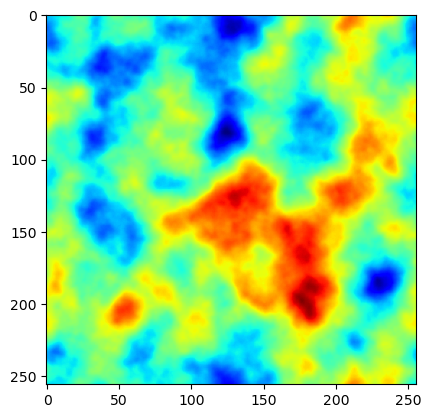

In [46]:
# create the figure and axes objects
fig, ax = plt.subplots()

# set the initial image
# im = ax.imshow(ns_data[0], animated=True, vmin=-20, vmax=10, cmap='jet')
im = ax.imshow(ns_data[0], animated=True, cmap='jet')

def update(i):
    im.set_array(ns_data[i])
    return im,

# create the animation object
animation_fig = animation.FuncAnimation(fig, update, frames=len(ns_data), interval=20, blit=True, repeat_delay=1,)

# Show the animation
plt.show()

animation_fig.save(f"animation/NS_generated_{idx}.gif")